 # Notebook 10: Implicit Bias Detection

 ## Purpose
 - Detect subtle bias through word associations
 - Analyze stereotype-counterstereotype proximity
 - Measure implicit associations (IAT-inspired)
 - Identify framing and priming effects
 - Narrative structure analysis
 - Hero/villain role assignment
 - Problem/solution framing by demographics

 ## Inputs
 - `data/processed/articles_with_events_sample_30000.csv`

 ## Outputs
 - `data/processed/implicit_bias_features_sample_30000.parquet`

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("Libraries imported")

Libraries imported


In [2]:
BASE_DIR = Path('..')
PROCESSED_DIR = BASE_DIR / 'data' / 'processed'

INPUT_FILE = PROCESSED_DIR / 'articles_with_events.csv'
OUTPUT_FILE = PROCESSED_DIR / 'implicit_bias_features.parquet'

print("Paths configured")

Paths configured


 ## 1. Load Data

In [3]:
print("Loading data...")
df = pd.read_csv(INPUT_FILE)
text_col = 'article_text' if 'article_text' in df.columns else 'text'
df['text'] = df[text_col].fillna('')

print(f"Loaded {len(df):,} articles")
print(f"  Avg text length: {df['text'].str.len().mean():.0f} characters")

Loading data...
Loaded 49,926 articles
  Avg text length: 2709 characters


 ## 2. Implicit Association Measures (IAT-Inspired)

In [4]:
print("\n=== IMPLICIT ASSOCIATION MEASURES ===")

# Stereotype associations (based on IAT research)
IMPLICIT_ASSOCIATIONS = {
    # Religion + negativity
    'muslim_violence': [
        r'muslim.*terror', r'muslim.*violent', r'islamic.*extremi',
        r'muslim.*attack', r'islamic.*radical'
    ],
    'muslim_threat': [
        r'muslim.*threat', r'islamic.*danger', r'muslim.*fear'
    ],

    # Gender + traits
    'women_emotional': [
        r'woman.*emotional', r'women.*irrational', r'female.*hysterical',
        r'woman.*sensitive', r'women.*overreact'
    ],
    'women_weak': [
        r'woman.*weak', r'female.*fragile', r'women.*vulnerable'
    ],

    # Caste + negativity
    'dalit_poor': [
        r'dalit.*poor', r'sc.*poverty', r'dalit.*backward'
    ],
    'dalit_oppressed': [
        r'dalit.*oppressed', r'dalit.*victim', r'dalit.*suffering'
    ],

    # Class + traits
    'poor_lazy': [
        r'poor.*lazy', r'poverty.*unwilling', r'poor.*don.*work'
    ],
    'rich_smart': [
        r'rich.*intelligent', r'wealthy.*smart', r'affluent.*educated'
    ],

    # Age + capability
    'elderly_weak': [
        r'elderly.*frail', r'old.*weak', r'senior.*helpless'
    ],
    'youth_irresponsible': [
        r'young.*reckless', r'youth.*irresponsible', r'teenager.*trouble'
    ],

    # Region + stereotypes
    'rural_backward': [
        r'rural.*backward', r'village.*primitive', r'rural.*uneducated'
    ],
    'urban_modern': [
        r'urban.*modern', r'city.*progressive', r'urban.*educated'
    ]
}

print("\nCalculating implicit bias patterns...")

for assoc_name, patterns in IMPLICIT_ASSOCIATIONS.items():
    df[f'implicit_{assoc_name}'] = df['text'].apply(
        lambda x: sum(len(re.findall(p, x.lower())) for p in patterns) if x else 0
    )

implicit_cols = [c for c in df.columns if c.startswith('implicit_')]
df['total_implicit_bias'] = df[implicit_cols].sum(axis=1)

print(f"Detected {len(implicit_cols)} implicit bias patterns")
print(f"  Articles with implicit bias: {(df['total_implicit_bias'] > 0).sum():,}")


=== IMPLICIT ASSOCIATION MEASURES ===

Calculating implicit bias patterns...
Detected 12 implicit bias patterns
  Articles with implicit bias: 2,262


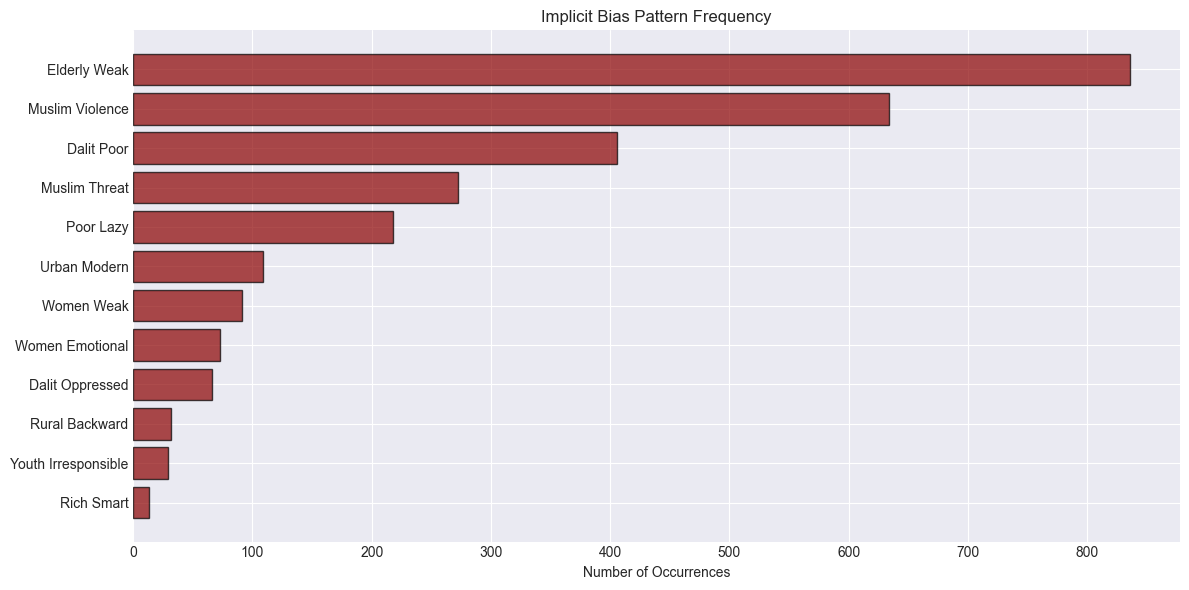

In [5]:
# Visualize implicit bias patterns
pattern_counts = {
    col.replace('implicit_', ''): df[col].sum()
    for col in implicit_cols
}

sorted_patterns = dict(sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_patterns)), list(sorted_patterns.values()),
         color='darkred', edgecolor='black', alpha=0.7)
plt.yticks(range(len(sorted_patterns)),
           [p.replace('_', ' ').title() for p in sorted_patterns.keys()])
plt.xlabel('Number of Occurrences')
plt.title('Implicit Bias Pattern Frequency')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### Key Insights: Implicit Bias Pattern Frequency

1) Negative stereotypes dominate and concentrate on a few groups – the most frequent patterns are Elderly Weak, Muslim Violence, Dalit Poor, Muslim Threat and Poor Lazy, showing that age, religion and caste groups are repeatedly framed in deficit terms.

2) Other groups and positive framings are much rarer – patterns involving women, rural groups, youth or “rich/smart” occur far less often, indicating that implicit bias is both unevenly distributed across groups and skewed toward negative characterizations.

 ## 3. Word Proximity Analysis

In [6]:
print("\n=== WORD PROXIMITY ANALYSIS ===")


def measure_proximity(text, target_group, attribute_words, window=50):
    '''Measure how often target group appears near attribute words'''
    if not text:
        return 0

    text_lower = text.lower()
    count = 0

    # Find all occurrences of target group
    for match in re.finditer(re.escape(target_group), text_lower):
        start = max(0, match.start() - window)
        end = min(len(text_lower), match.end() + window)
        context = text_lower[start:end]

        # Check if any attribute appears in context
        for attr in attribute_words:
            if attr in context:
                count += 1
                break

    return count


# Define proximity pairs (stereotype-counterstereotype)
PROXIMITY_PAIRS = {
    'muslim_negative': ('muslim', ['terror', 'violent', 'extremist', 'threat', 'radical']),
    'muslim_positive': ('muslim', ['peaceful', 'moderate', 'community', 'diverse']),

    'women_emotional': ('women', ['emotional', 'sensitive', 'irrational', 'hysterical']),
    'women_strong': ('women', ['strong', 'leader', 'powerful', 'confident']),

    'dalit_negative': ('dalit', ['poor', 'backward', 'untouchable', 'oppressed']),
    'dalit_positive': ('dalit', ['rights', 'empowered', 'educated', 'leader']),

    'poor_negative': ('poor', ['lazy', 'uneducated', 'backward', 'crime']),
    'poor_positive': ('poor', ['hardworking', 'struggling', 'deserve', 'help'])
}

print("\nCalculating proximity measures...")

for proximity_name, (target, attributes) in PROXIMITY_PAIRS.items():
    df[f'proximity_{proximity_name}'] = df['text'].apply(
        lambda x: measure_proximity(x, target, attributes)
    )

proximity_cols = [c for c in df.columns if c.startswith('proximity_')]

print(f"Calculated {len(proximity_cols)} proximity measures")


=== WORD PROXIMITY ANALYSIS ===

Calculating proximity measures...
Calculated 8 proximity measures


In [7]:
# Calculate stereotype vs counterstereotype balance
df['muslim_proximity_balance'] = (
    df['proximity_muslim_positive'] - df['proximity_muslim_negative']
) / (df['proximity_muslim_positive'] + df['proximity_muslim_negative'] + 1)

df['women_proximity_balance'] = (
    df['proximity_women_strong'] - df['proximity_women_emotional']
) / (df['proximity_women_strong'] + df['proximity_women_emotional'] + 1)

df['dalit_proximity_balance'] = (
    df['proximity_dalit_positive'] - df['proximity_dalit_negative']
) / (df['proximity_dalit_positive'] + df['proximity_dalit_negative'] + 1)

df['poor_proximity_balance'] = (
    df['proximity_poor_positive'] - df['proximity_poor_negative']
) / (df['proximity_poor_positive'] + df['proximity_poor_negative'] + 1)

print("Proximity balance calculated")

Proximity balance calculated


 ## 4. Narrative Structure Analysis

In [8]:
print("\n=== NARRATIVE STRUCTURE ANALYSIS ===")

# Define narrative markers
NARRATIVE_MARKERS = {
    # Conflict markers
    'conflict': [
        r'conflict', r'dispute', r'clash', r'fight', r'battle',
        r'struggle', r'confrontation', r'tension'
    ],

    # Resolution markers
    'resolution': [
        r'resolved', r'settled', r'agreed', r'compromise', r'solution',
        r'peace', r'reconciliation', r'unity'
    ],

    # Victim markers
    'victim': [
        r'victim', r'suffered', r'affected', r'harmed', r'injured',
        r'targeted', r'discriminated', r'oppressed'
    ],

    # Perpetrator markers
    'perpetrator': [
        r'accused', r'alleged', r'blamed', r'responsible', r'perpetrator',
        r'culprit', r'attacker', r'offender'
    ],

    # Success markers
    'success': [
        r'succeeded', r'achieved', r'won', r'victory', r'triumph',
        r'accomplished', r'overcame'
    ],

    # Failure markers
    'failure': [
        r'failed', r'defeated', r'lost', r'unsuccessful', r'collapsed',
        r'struggled', r'unable'
    ]
}

print("\nAnalyzing narrative structures...")

for marker_type, patterns in NARRATIVE_MARKERS.items():
    df[f'narrative_{marker_type}'] = df['text'].apply(
        lambda x: sum(len(re.findall(p, x.lower())) for p in patterns) if x else 0
    )

narrative_cols = [c for c in df.columns if c.startswith('narrative_')]

# Calculate narrative ratios
df['narrative_conflict_resolution_ratio'] = (
    df['narrative_conflict'] / (df['narrative_resolution'] + 1)
)

df['narrative_victim_perpetrator_ratio'] = (
    df['narrative_victim'] / (df['narrative_perpetrator'] + 1)
)

df['narrative_success_failure_ratio'] = (
    df['narrative_success'] / (df['narrative_failure'] + 1)
)

print(f"Analyzed {len(narrative_cols)} narrative markers")


=== NARRATIVE STRUCTURE ANALYSIS ===

Analyzing narrative structures...
Analyzed 6 narrative markers


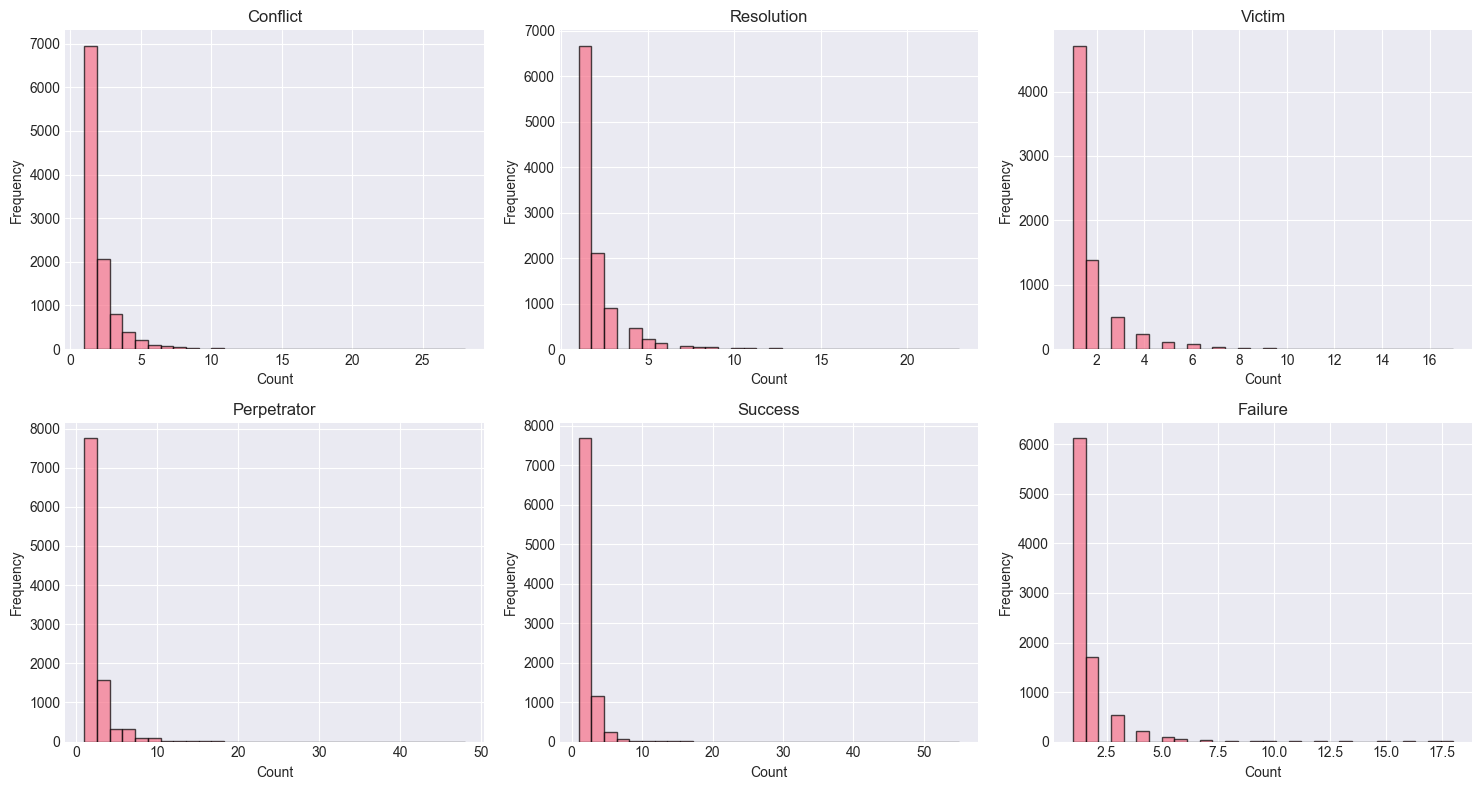

In [9]:
# Visualize narrative patterns
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, col in enumerate(narrative_cols):
    data = df[df[col] > 0][col]
    if len(data) > 0:
        axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7)
        axes[idx].set_xlabel('Count')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(col.replace('narrative_', '').title())

plt.tight_layout()
plt.show()

#### Key Insights: Narrative Framing Patterns

1) All narrative frames are used sparingly, with counts for conflict, resolution, victim, perpetrator, success, and failure terms heavily concentrated at very low values (typically 0–2 per article), and only a small tail of articles using them intensively.

2) When framing language does ramp up, it skews toward conflict, perpetrators, and success, which show the longest right tails, indicating that strongly framed stories tend to focus more on clashes and actors than on victims, resolution, or failure.

 ## 5. Hero/Villain Role Assignment Detection

In [10]:
print("\n=== HERO/VILLAIN ROLE ASSIGNMENT ===")

# Define demographic groups
DEMOGRAPHIC_GROUPS = {
    'muslim': r'\b(muslim|islamic|islam)\b',
    'hindu': r'\b(hindu|hindutva)\b',
    'christian': r'\b(christian|church)\b',
    'women': r'\b(women|woman|female|girl)\b',
    'men': r'\b(men|man|male|boy)\b',
    'dalit': r'\b(dalit|sc|scheduled caste)\b',
    'upper_caste': r'\b(brahmin|upper caste)\b',
    'poor': r'\b(poor|poverty|slum)\b',
    'rich': r'\b(rich|wealthy|affluent|elite)\b',
    'rural': r'\b(rural|village|farmer)\b',
    'urban': r'\b(urban|city|metropolitan)\b',
    'youth': r'\b(youth|young|teenager|student)\b',
    'elderly': r'\b(elderly|senior|old)\b'
}

# Define role indicators
ROLE_INDICATORS = {
    'hero': [
        r'hero', r'savior', r'champion', r'defender', r'protector',
        r'leader', r'pioneer', r'activist', r'advocate', r'fighter'
    ],
    'villain': [
        r'villain', r'criminal', r'terrorist', r'extremist', r'militant',
        r'accused', r'suspect', r'perpetrator', r'attacker', r'offender'
    ],
    'victim': [
        r'victim', r'affected', r'suffered', r'harmed', r'targeted',
        r'discriminated', r'oppressed', r'vulnerable', r'helpless'
    ],
    'neutral': [
        r'person', r'people', r'individual', r'citizen', r'resident',
        r'member', r'community'
    ]
}

print("\nDetecting role assignments...")


def detect_role_assignment(text, demographic_pattern, role_patterns, window=100):
    """Detect when a demographic group is assigned a specific role"""
    if not text:
        return 0

    text_lower = text.lower()
    count = 0

    # Find demographic mentions
    for match in re.finditer(demographic_pattern, text_lower):
        start = max(0, match.start() - window)
        end = min(len(text_lower), match.end() + window)
        context = text_lower[start:end]

        # Check if role appears in context
        for pattern in role_patterns:
            if re.search(pattern, context):
                count += 1
                break

    return count


# Calculate role assignments for each demographic
for demo_name, demo_pattern in DEMOGRAPHIC_GROUPS.items():
    for role_name, role_patterns in ROLE_INDICATORS.items():
        col_name = f'role_{demo_name}_{role_name}'
        df[col_name] = df['text'].apply(
            lambda x: detect_role_assignment(x, demo_pattern, role_patterns)
        )

role_cols = [c for c in df.columns if c.startswith('role_')]

print(f"Detected {len(role_cols)} role assignment patterns")


=== HERO/VILLAIN ROLE ASSIGNMENT ===

Detecting role assignments...
Detected 52 role assignment patterns


In [11]:
# Analyze role distribution by demographic
role_distribution = {}

for demo_name in DEMOGRAPHIC_GROUPS.keys():
    demo_roles = {
        'hero': df[f'role_{demo_name}_hero'].sum(),
        'villain': df[f'role_{demo_name}_villain'].sum(),
        'victim': df[f'role_{demo_name}_victim'].sum(),
        'neutral': df[f'role_{demo_name}_neutral'].sum()
    }
    role_distribution[demo_name] = demo_roles

role_df = pd.DataFrame(role_distribution).T
print("\nRole assignments by demographic group:")
print(role_df)


Role assignments by demographic group:
             hero  villain  victim  neutral
muslim        368      398      86      841
hindu         215       96      40      327
christian      86       44      20      201
women         896      742     404     1966
men           715      502     222     1413
dalit         192       61      42      318
upper_caste    26        5       1       67
poor          124       33      97      640
rich           75       29      28      257
rural         302      283     210     1296
urban         581      313     159     1478
youth         573      255     147     1247
elderly      2919      631     366     2757


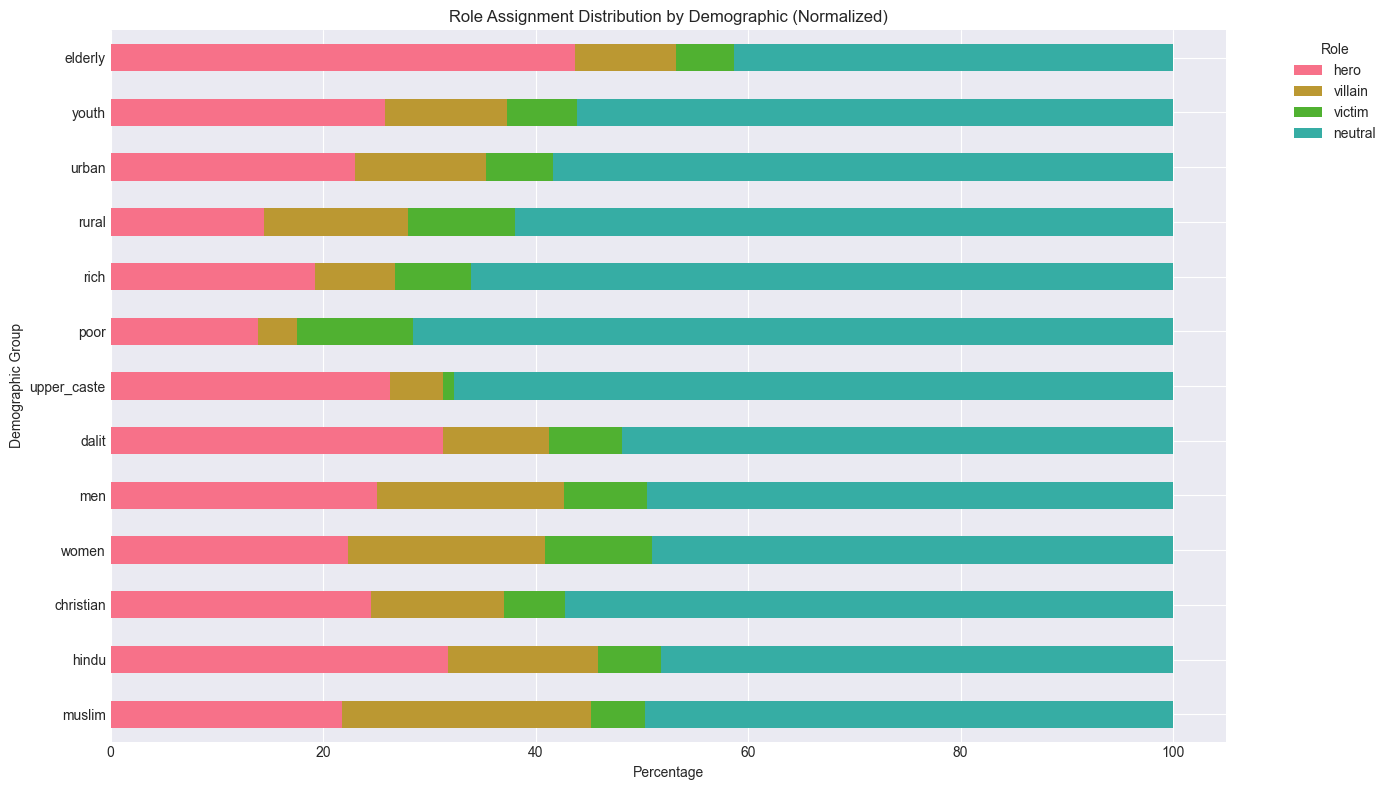

In [12]:
# Visualize role assignments
fig, ax = plt.subplots(figsize=(14, 8))

role_df_normalized = role_df.div(role_df.sum(axis=1), axis=0) * 100
role_df_normalized.plot(kind='barh', stacked=True, ax=ax)

ax.set_xlabel('Percentage')
ax.set_ylabel('Demographic Group')
ax.set_title('Role Assignment Distribution by Demographic (Normalized)')
ax.legend(title='Role', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Key Insights: Role Assignment by Demographic

1) Most groups are framed neutrally overall, but non‑neutral roles are patterned: marginalised groups like poor, Dalits, women, rural and elderly appear more often as victims, while privileged/centre groups like rich, upper caste, urban, men more frequently appear in hero/agentic roles.

2) Some groups are disproportionately associated with villain roles – notably Muslims, rural groups and men have a higher share of villain assignments relative to others, whereas groups like Hindus, Christians and youth lean more toward hero framing when they are not neutral.

In [13]:
# Calculate hero-villain bias score for each demographic
print("\nHero-Villain Bias Scores:")
for demo_name in DEMOGRAPHIC_GROUPS.keys():
    hero_count = df[f'role_{demo_name}_hero'].sum()
    villain_count = df[f'role_{demo_name}_villain'].sum()

    if hero_count + villain_count > 0:
        bias_score = (hero_count - villain_count) / (hero_count + villain_count)
        print(f"  {demo_name:15s}: {bias_score:6.3f} (hero={hero_count}, villain={villain_count})")


Hero-Villain Bias Scores:
  muslim         : -0.039 (hero=368, villain=398)
  hindu          :  0.383 (hero=215, villain=96)
  christian      :  0.323 (hero=86, villain=44)
  women          :  0.094 (hero=896, villain=742)
  men            :  0.175 (hero=715, villain=502)
  dalit          :  0.518 (hero=192, villain=61)
  upper_caste    :  0.677 (hero=26, villain=5)
  poor           :  0.580 (hero=124, villain=33)
  rich           :  0.442 (hero=75, villain=29)
  rural          :  0.032 (hero=302, villain=283)
  urban          :  0.300 (hero=581, villain=313)
  youth          :  0.384 (hero=573, villain=255)
  elderly        :  0.645 (hero=2919, villain=631)


 ## 6. Problem/Solution Framing by Demographics

In [14]:
print("\n=== PROBLEM/SOLUTION FRAMING ===")

# Define problem and solution markers
PROBLEM_MARKERS = [
    r'problem', r'issue', r'crisis', r'challenge', r'difficulty',
    r'trouble', r'concern', r'threat', r'danger', r'risk'
]

SOLUTION_MARKERS = [
    r'solution', r'resolve', r'fix', r'solve', r'address',
    r'tackle', r'overcome', r'improve', r'enhance', r'help'
]

print("\nAnalyzing problem/solution framing...")


def detect_framing(text, demographic_pattern, framing_patterns, window=100):
    """Detect when a demographic is framed as problem or solution"""
    if not text:
        return 0

    text_lower = text.lower()
    count = 0

    # Find demographic mentions
    for match in re.finditer(demographic_pattern, text_lower):
        start = max(0, match.start() - window)
        end = min(len(text_lower), match.end() + window)
        context = text_lower[start:end]

        # Check if framing appears in context
        for pattern in framing_patterns:
            if re.search(pattern, context):
                count += 1
                break

    return count


# Calculate problem/solution framing for each demographic
for demo_name, demo_pattern in DEMOGRAPHIC_GROUPS.items():
    df[f'framing_{demo_name}_problem'] = df['text'].apply(
        lambda x: detect_framing(x, demo_pattern, PROBLEM_MARKERS)
    )
    df[f'framing_{demo_name}_solution'] = df['text'].apply(
        lambda x: detect_framing(x, demo_pattern, SOLUTION_MARKERS)
    )

framing_cols = [c for c in df.columns if c.startswith('framing_')]

print(f"Analyzed problem/solution framing for {len(DEMOGRAPHIC_GROUPS)} demographics")


=== PROBLEM/SOLUTION FRAMING ===

Analyzing problem/solution framing...


Analyzed problem/solution framing for 13 demographics


In [15]:
# Calculate framing balance (problem vs solution)
framing_balance = {}

for demo_name in DEMOGRAPHIC_GROUPS.keys():
    problem_count = df[f'framing_{demo_name}_problem'].sum()
    solution_count = df[f'framing_{demo_name}_solution'].sum()

    if problem_count + solution_count > 0:
        balance = (solution_count - problem_count) / (solution_count + problem_count)
        framing_balance[demo_name] = {
            'problem': problem_count,
            'solution': solution_count,
            'balance': balance
        }

framing_df = pd.DataFrame(framing_balance).T
print("\nProblem/Solution Framing Balance:")
print(framing_df.round(3))


Problem/Solution Framing Balance:
             problem  solution  balance
muslim         343.0     166.0   -0.348
hindu          203.0      63.0   -0.526
christian       90.0      50.0   -0.286
women         1004.0     649.0   -0.215
men            601.0     406.0   -0.194
dalit          137.0      75.0   -0.292
upper_caste     13.0       5.0   -0.444
poor           368.0     292.0   -0.115
rich            78.0      86.0    0.049
rural          350.0     375.0    0.034
urban          914.0     429.0   -0.361
youth          470.0     407.0   -0.072
elderly       1109.0     730.0   -0.206


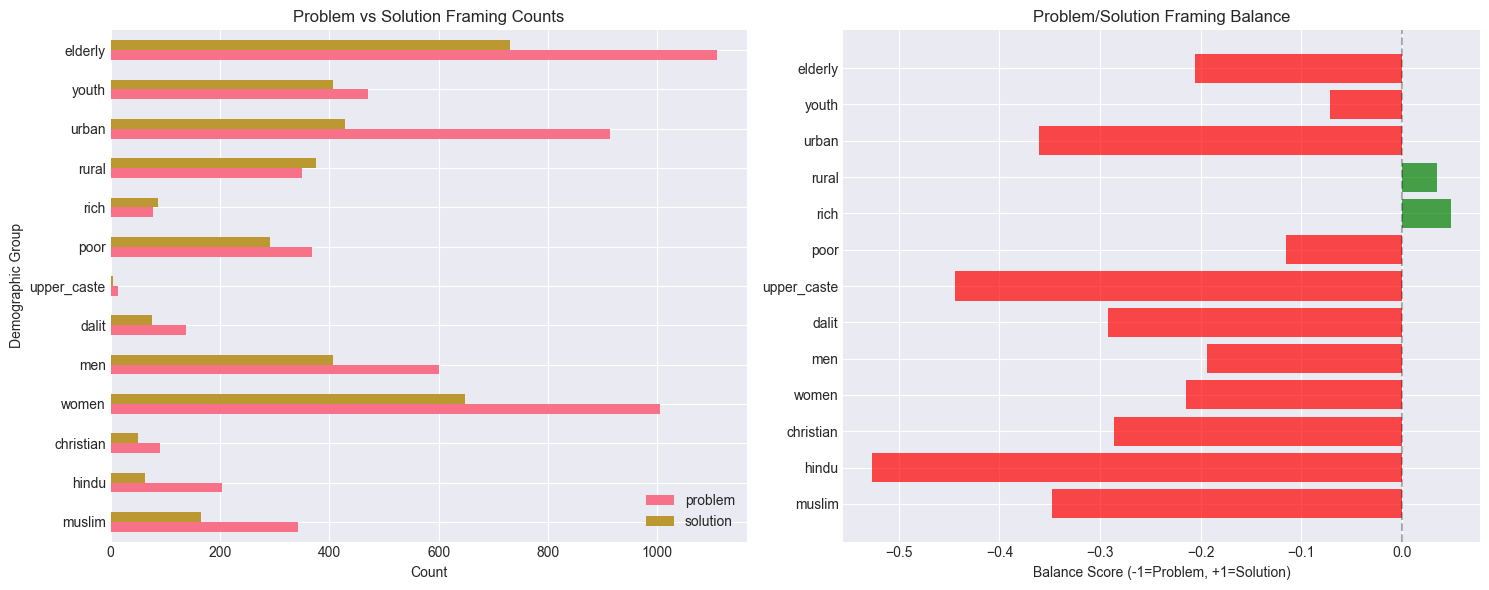

In [16]:
# Visualize problem/solution framing
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Problem vs solution counts
ax1 = axes[0]
framing_df[['problem', 'solution']].plot(kind='barh', ax=ax1)
ax1.set_xlabel('Count')
ax1.set_ylabel('Demographic Group')
ax1.set_title('Problem vs Solution Framing Counts')
ax1.legend()

# Framing balance
ax2 = axes[1]
colors = ['red' if x < 0 else 'green' for x in framing_df['balance']]
ax2.barh(range(len(framing_df)), framing_df['balance'], color=colors, alpha=0.7)
ax2.set_yticks(range(len(framing_df)))
ax2.set_yticklabels(framing_df.index)
ax2.set_xlabel('Balance Score (-1=Problem, +1=Solution)')
ax2.set_title('Problem/Solution Framing Balance')
ax2.axvline(0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

#### Key Insights: Problem vs Solution Framing by Group

1) Most demographic groups are framed more as “problems” than “solutions”, with problem‑oriented mentions clearly outnumbering solution‑oriented ones for groups like elderly, youth, urban, poor, Dalits, men, women, Hindus and Muslims.

2) Only rich and rural groups show a slight solution‑leaning balance, while Hindus, Muslims and upper‑caste groups have the strongest negative balance scores, indicating they are especially likely to appear in problem‑focused narratives rather than in solution contexts

 ## 7. Framing Effects (Positive vs Negative)

In [17]:
print("\n=== POSITIVE VS NEGATIVE FRAMING ===")

# Positive vs negative framing for same groups
FRAMING_PATTERNS = {
    'muslim_positive': [r'muslim.*peaceful', r'muslim.*moderate', r'muslim.*community'],
    'muslim_negative': [r'muslim.*extremist', r'muslim.*terrorist', r'muslim.*radical'],

    'women_strong': [r'women.*strong', r'women.*leader', r'women.*powerful'],
    'women_weak': [r'women.*victim', r'women.*helpless', r'women.*vulnerable'],

    'poor_deserving': [r'poor.*hardworking', r'poor.*struggling', r'poor.*deserve'],
    'poor_undeserving': [r'poor.*lazy', r'poor.*dependent', r'poor.*welfare'],

    'dalit_empowered': [r'dalit.*rights', r'dalit.*empowered', r'dalit.*leader'],
    'dalit_oppressed': [r'dalit.*oppressed', r'dalit.*victim', r'dalit.*backward']
}

print("\nCalculating framing patterns...")

for frame_name, patterns in FRAMING_PATTERNS.items():
    df[f'frame_{frame_name}'] = df['text'].apply(
        lambda x: sum(len(re.findall(p, x.lower())) for p in patterns) if x else 0
    )

# Calculate framing balance
df['muslim_framing_balance'] = (
    df['frame_muslim_positive'] - df['frame_muslim_negative']
) / (df['frame_muslim_positive'] + df['frame_muslim_negative'] + 1)

df['women_framing_balance'] = (
    df['frame_women_strong'] - df['frame_women_weak']
) / (df['frame_women_strong'] + df['frame_women_weak'] + 1)

df['poor_framing_balance'] = (
    df['frame_poor_deserving'] - df['frame_poor_undeserving']
) / (df['frame_poor_deserving'] + df['frame_poor_undeserving'] + 1)

df['dalit_framing_balance'] = (
    df['frame_dalit_empowered'] - df['frame_dalit_oppressed']
) / (df['frame_dalit_empowered'] + df['frame_dalit_oppressed'] + 1)

print("Framing analysis complete")


=== POSITIVE VS NEGATIVE FRAMING ===

Calculating framing patterns...
Framing analysis complete


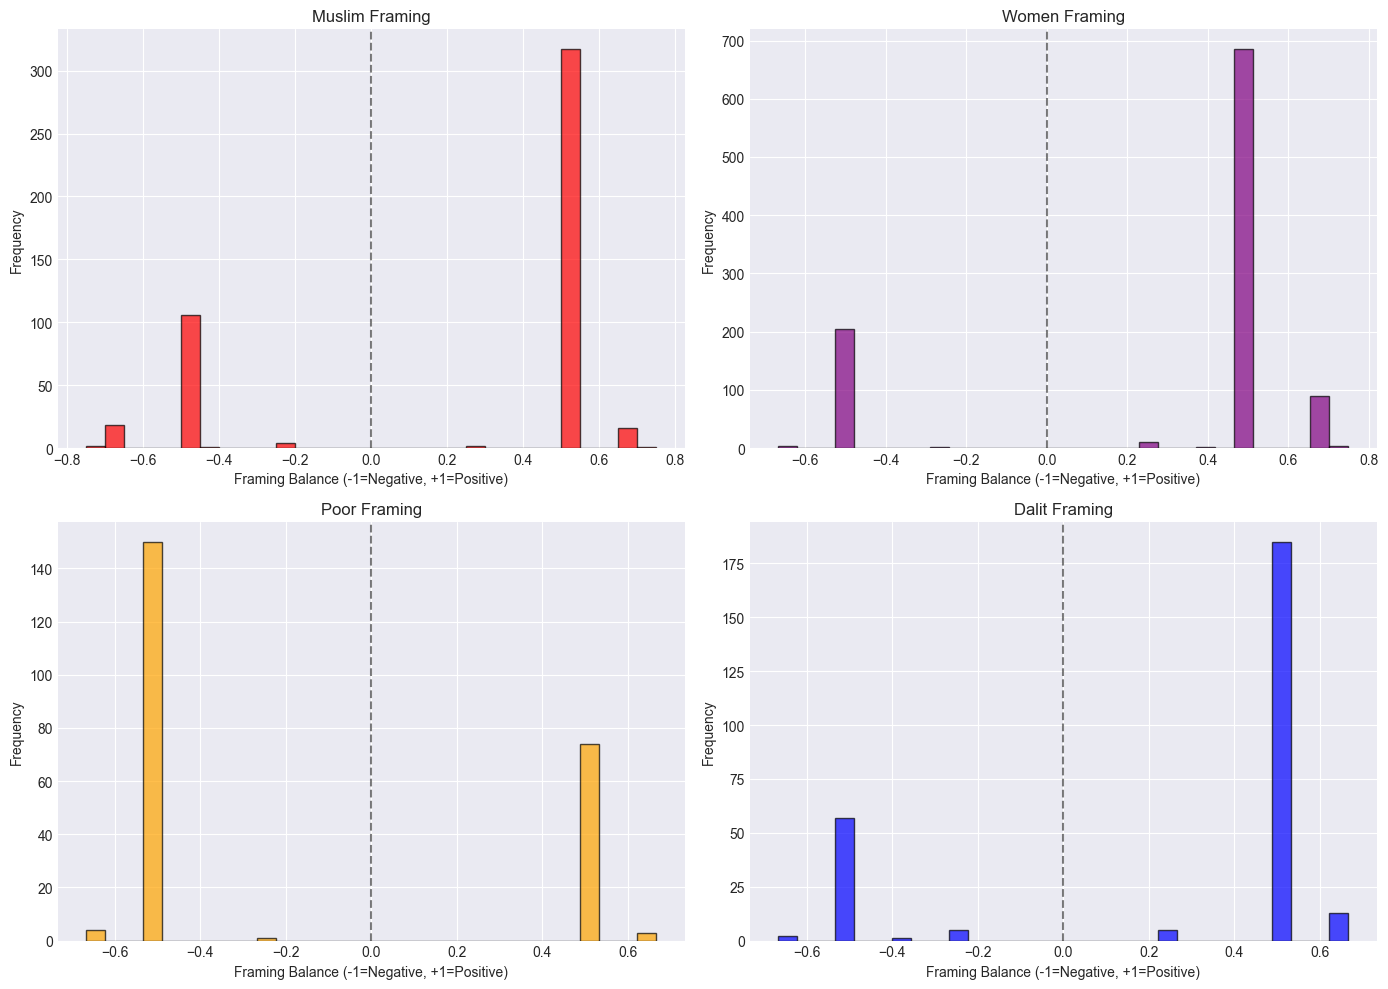

In [18]:
# Visualize framing balance
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

framing_cols = ['muslim_framing_balance', 'women_framing_balance',
                'poor_framing_balance', 'dalit_framing_balance']
titles = ['Muslim Framing', 'Women Framing', 'Poor Framing', 'Dalit Framing']
colors = ['red', 'purple', 'orange', 'blue']

for idx, (col, title, color) in enumerate(zip(framing_cols, titles, colors)):
    data = df[df[col] != 0][col]
    if len(data) > 0:
        axes[idx].hist(data, bins=30, edgecolor='black', alpha=0.7, color=color)
        axes[idx].set_xlabel('Framing Balance (-1=Negative, +1=Positive)')
        axes[idx].set_ylabel('Frequency')
        axes[idx].set_title(title)
        axes[idx].axvline(0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

##### Key Insights: Group-Specific Framing Balance

1) Framing is strongly polarized rather than neutral – for all four groups (Muslim, women, poor, Dalit), articles cluster around clearly positive or clearly negative balance scores, with relatively few neutrally framed stories.

2) Muslims, women and Dalits are mostly framed positively, while the poor are more often framed negatively – however, each group still has a noticeable block of strongly negative coverage, indicating persistent pockets of deficit or stereotyped narratives, especially pronounced for the poor and for Muslims

 ## 8. Feature Summary and Compilation

In [19]:
print("\n=== FEATURE SUMMARY ===")

# Compile all implicit bias features (remove duplicates)
implicit_features_raw = (
    implicit_cols
    + proximity_cols
    + narrative_cols
    + role_cols
    + framing_cols
    + [f'frame_{name}' for name in FRAMING_PATTERNS.keys()]
    + ['muslim_framing_balance', 'women_framing_balance', 'poor_framing_balance', 'dalit_framing_balance']
    + ['muslim_proximity_balance', 'women_proximity_balance', 'dalit_proximity_balance', 'poor_proximity_balance']
    + ['narrative_conflict_resolution_ratio', 'narrative_victim_perpetrator_ratio', 'narrative_success_failure_ratio']
    + ['total_implicit_bias']
)

# Remove duplicates while preserving order
implicit_features = list(dict.fromkeys(implicit_features_raw))

print(f"\nTotal implicit bias features: {len(implicit_features)}")
print(f"  - Implicit associations: {len(implicit_cols)}")
print(f"  - Proximity measures: {len(proximity_cols)}")
print(f"  - Narrative markers: {len(narrative_cols)}")
print(f"  - Role assignments: {len(role_cols)}")
print(f"  - Framing patterns: {len(framing_cols)}")
print(f"  - Balance scores: {len([f for f in implicit_features if 'balance' in f or 'ratio' in f])}")


=== FEATURE SUMMARY ===

Total implicit bias features: 98
  - Implicit associations: 12
  - Proximity measures: 8
  - Narrative markers: 6
  - Role assignments: 52
  - Framing patterns: 4
  - Balance scores: 11


 ## 9. Save Implicit Bias Features

In [20]:
print("\n=== SAVING FEATURES ===")

columns_to_save = ['url'] + implicit_features
df_implicit = df[columns_to_save].copy()

print(f"\nSaving implicit bias features...")
df_implicit.to_parquet(OUTPUT_FILE, index=False, compression='snappy')

print(f"Saved to: {OUTPUT_FILE}")
print(f"  Size: {OUTPUT_FILE.stat().st_size / 1024**2:.2f} MB")
print(f"  Features: {len(implicit_features)}")


=== SAVING FEATURES ===

Saving implicit bias features...
Saved to: ../data/processed/implicit_bias_features.parquet
  Size: 3.02 MB
  Features: 98


 ## 10. Summary Report

INPUT:
  Articles analyzed: 49,926
  Avg text length: 2709 characters

OUTPUT:
  Total features: 98

KEY FINDINGS:

1. IMPLICIT ASSOCIATIONS:
   - Articles with implicit bias: 2,262
   - Avg implicit bias score: 0.06
   - Top pattern: Elderly Weak

2. PROXIMITY ANALYSIS:
   - Muslim proximity balance: 0.001
   - Women proximity balance: 0.001
   - Dalit proximity balance: 0.000

3. NARRATIVE STRUCTURES:
   - Conflict-resolution ratio: 0.29
   - Victim-perpetrator ratio: 0.17
   - Success-failure ratio: 0.24

4. ROLE ASSIGNMENTS:
   - Demographics analyzed: 13
   - Role patterns detected: 4

5. PROBLEM/SOLUTION FRAMING:
   - Most framed as problem: elderly
   - Most framed as solution: elderly